# Unveiling the Power of Large Language Models in Text-to-Image Synthesis Evaluation

### Group Members:
1.   Muhammad Umer (m1umer@torontomu.ca)
2.   Kami Wang (kami.wang@torontomu.ca)



# Introduction:

### Problem Description:

This paper aims to explore a new framework that offers evaluation scores with multi-granularitybcompositionality by using language models(LLMs) called LLMScore. By merging various features, LLMScore generates comprehensive image descriptions. It uses LLMs to assess aligenment between provide images and text that user provides. This approach provides a powerful method for assessing the accuracy of provide text and images. It provides a more accurate assessment than existing methods.
<br><br>

### Context of the Problem:

Existing methods use automatic evaluation on text-to-image synthesis provide only a single score that shows how well the text matches the whole image, without considering the details of the objects in the image. This limitation results in a poor correlation with human judgements, since human considers the differences of every single item on the image.
<br><br>


### Limitation About other Approaches:

The paper also discusses the limitations and potential biases associated with using LLMs. The challenges such as accurately capturing composite text-to-image alignment, for example couting, color, location, etc. They will affect producing the score and evaluating with various objects.
<br><br>


### Solution:

LLMScore utilizes the incredible text reasoning ad generation ability of Large Language Models(LLMs) to imitate human evaluation processes, offering insights into model performance by assessing compositionality at multi-levels. Then by combining visual and language models with text prompts, LLMScore transforms images into detailed descriptions, enabling the evaluation of alignment with text prompts using LLMs such as GPT-4.

<br>

# Background


| Reference |Explanation |  Dataset/Input |Weakness
| --- | --- | --- | --- |
| Inception Score [1] | They can recognized metircs for the quality ad diversity of generated images| generated images | poor alignment
| CLIPScore [2] | Measureing alignment in text-to-image that rely on pre-trained matching model, most common | generated images and text prompts | not very accurate with generate rationales
| LLMs [3] | Evaluate natural language generation tasks, recently common on text-to-image synthesis evaluation. | generated images and text prompts | rely on paid openAI KEY-GPT4

# Methodology

Using LLMs and multi-granularity visual descriptor, the goal is to capture alignment between image and text. First we decompose the image into 2 levels:

*   **Image-level global description:** Using image captioning model BLIPv2 that caputure the primary context of the image, which helps in the understanding of the location of each object, and interaction among objects.
*   **Region-level local descriptions:** Only provide detailed information about each region and transform them into textual descriptions using GRiT [50].

![image1](https://drive.google.com/uc?id=1rrYBbFek1ou8l_vAok_J5xlcUb9ig6V4)

As the text-to-image evaluator, use the resulting descriptions made by LLMs to evaluate the alignment between the images and the text prompts. Next step is generating ratings.

*   **Instruction-Following Rating:** Rating the alignment between the generated image and text using LLMs based on given instructions such as overall semantics, error counting etc.
*   **Rule-enhanced rating:**  Restrict LLMs to a wider range of ratings, and using atomic tasks and calculate the final evaluation score by `(ratio of the number of matched objects in the text)/2 + (ratio of the number of matched attributes in the text)/2`. The results will be more accurate and close to human judgment.

![image2](https://drive.google.com/uc?id=1AssJc4tgQVx61cHD3rAQmY0TnAyFj-3s)

Finally, based on the scores that LLMs generate, it also has to generate rationales into their decision-making process, including "overall_rationale" and "error_counting_rationale".

![image3](https://drive.google.com/uc?id=1qH9wyH4ARISz4dMDZ4Au_TLwI97YD1dO)

# Implementation

This is the setup for initial LLMScore repo and relevant model dependency management. These initial steps are as follows:


1.   Set OPENAI_KEY for session
2.   Clone LLMScore repository
3.   Setup detectron
4.   Install transformers library
5.   Download grit models



In [ ]:
import os
# Set the OPENAI_KEY environment variable (you need to replace with your actual key)
os.environ['OPENAI_KEY'] = ''  # Replace YOUR_OPENAI_KEY with your actual OpenAI API key
os.environ['OPENAI_API_KEY'] = ''  # Replace YOUR_OPENAI_KEY with your actual OpenAI API key

# Clone the LLM repository
!git clone https://github.com/YujieLu10/LLMScore.git
%cd LLMScore

# Initiate and update the Detectron2 submodule
!git submodule update --init submodule/detectron2

# Install the Hugging Face Transformers library
%cd ../../
!pip install git+https://github.com/huggingface/transformers
%cd /LLMScore

# Download the GRiT Model
!mkdir -p models
%cd models
!wget https://datarelease.blob.core.windows.net/grit/models/grit_b_densecap_objectdet.pth
%cd ..

In [ ]:
# Install relevant dependencies
%cd /LLMScore
!pip install opencv-python mss timm ftfy regex fasttext scikit-learn lvis nltk tqdm matplotlib requests anytree boto3 scikit-image pyyaml inflect icecream openai protobuf einops deepspeed

# Install depedencies for detectron2
%cd /LLMScore/submodule/detectron2
!pip install -e .

%cd /LLMScore

In [ ]:
# Update the files with updated implemenation for OpenAPI methods
!cp /src/visual_descriptor.py /LLMScore/llm_descriptor/visual_descriptor.py
!cp /src/evaluation_instruction.py /LLMScore/llm_evaluator/evaluation_instruction.py

After the initial setup, the prompt evaluation is done on various pictures and their rationale and scores are analyzed
Build commands for the pictures and prompts:

*   All images should be in the folder - /src/samples
*   Name of the file should be the input prompt (Example file > a girl with red purse.jpg)
    
    
    

In [ ]:
import subprocess

def run_command(image, text_prompt):
    command = f"python llm_score.py --image '{image}' --text_prompt '{text_prompt}'"
    print(command)
    result = subprocess.run(command, shell=True, text=True, capture_output=True)
    if result.stderr:
        print("Error:", result.stderr)
    return result.stdout

def execute_commands(commands):
    outputs = []
    for image, prompt in commands:
        output = run_command(image, prompt)
        outputs.append(output)
    return outputs

def list_files_in_directory(directory):
    return [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

def create_commands(directory):
    files = list_files_in_directory(directory)
    commands = []
    for file in files:
        prompt = os.path.splitext(file)[0]  # Remove file extension for the prompt
        image_path = os.path.join(directory, file)  # Full path to the image
        commands.append((image_path, prompt.replace('_', ' ')))  # Replace underscores with spaces if needed
    return commands

image_directory = '/src/samples'

commands_to_run = create_commands(image_directory)

In [ ]:
# Execute all commands for input images and their corresponding prompt
outputs = execute_commands(commands_to_run)

In [ ]:
# Parse output to gather scores, errors and corresponding rationales
outputs_parsed = []

for output in outputs:
    lines = output.strip().split('\n')
    if len(lines) >= 4:
        parsed = {
            'overall_score': lines[-4].strip(),
            'overall_score_rationale': lines[-2].strip(),
            'error_counts': lines[-3].strip(),
            'error_rationale': lines[-1].strip()
        }
        outputs_parsed.append(parsed)

for parsed in outputs_parsed:
  print(parsed)

{'overall_score': '90', 'overall_score_rationale': 'The image description matches the text prompt very well, garnering a high score of 90 out of 100. It accurately describes a girl with a red purse, but it goes further into more specific detail about her overall attire, the look she portrays, and the environment around her.', 'error_counts': '0', 'error_rationale': "There are no identifiable composition errors in the image description in comparison to the text prompt. All the elements mentioned in the prompt, particularly the girl and her red purse, are accurately accounted for in the description. Moreover, no item discussed in the prompt is conspicuously absent or incorrectly described in the image's depiction."}
{'overall_score': '10', 'overall_score_rationale': 'The image description is of low overall quality in terms of matching the text prompt, earning a score of 10 out of 100. This is because the described image is fundamentally different from the text prompt, which speaks about 

In [ ]:
# Convert output to dataframe
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.DataFrame(outputs_parsed)
df['overall_score'] = df['overall_score'].astype(int)
df['error_counts'] = df['error_counts'].astype(int)

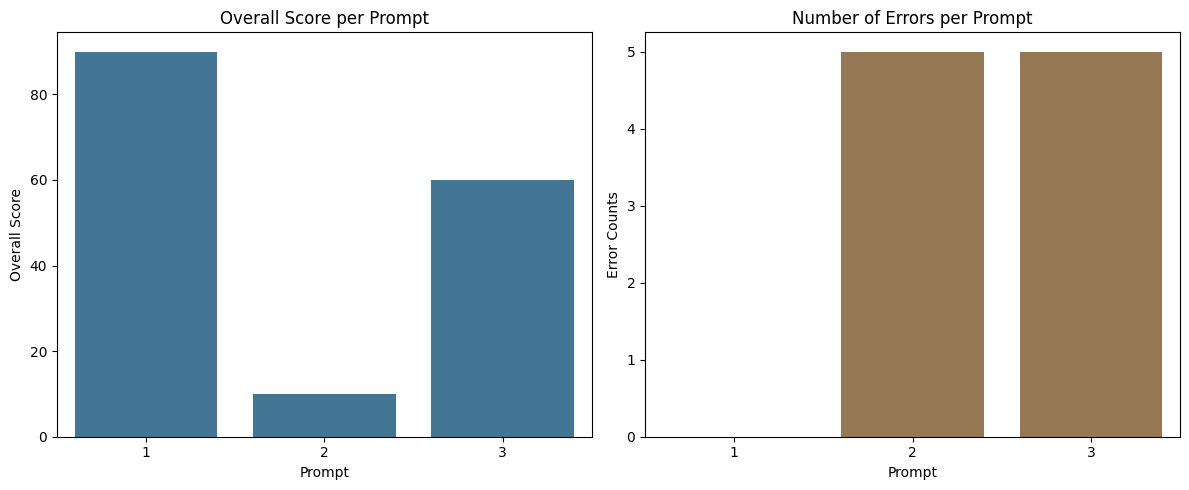

In [ ]:
# Plot scores and error counts for every prompt
plt.figure(figsize=(12, 5))

# Single color for each type of barplot
color_score = sns.color_palette("mako_r", 1)
color_error = sns.color_palette("cubehelix", 1)

# First subplot: Distribution of Scores
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.barplot(x=df.index + 1, y="overall_score", data=df, color=color_score[0])
plt.title('Overall Score per Prompt')
plt.xlabel('Prompt')
plt.ylabel('Overall Score')

# Second subplot: Number of Errors
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.barplot(x=df.index + 1, y="error_counts", data=df, color=color_error[0])
plt.title('Number of Errors per Prompt')
plt.xlabel('Prompt')
plt.ylabel('Error Counts')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

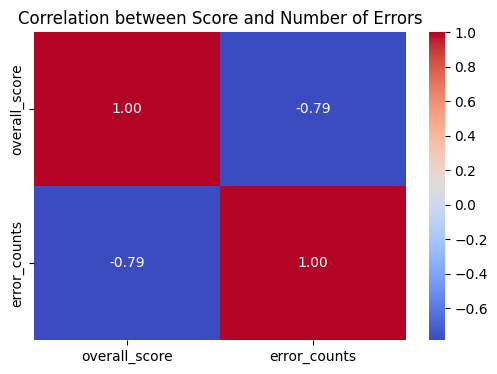

In [ ]:
# Corelation map b/w scores and errors
corr = df[['overall_score', 'error_counts']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Score and Number of Errors')
plt.show()

In [ ]:
# Average scores for all prompts
average_score = df['overall_score'].mean()
print(f'Average Score - Overall: {average_score:.2f}')

average_score = df['error_counts'].mean()
print(f'Average Score - Error Count: {average_score:.2f}')

Average Score - Overall: 53.33
Average Score - Error Count: 3.33


# Conclusion and Future Direction

**Conclusion**

*   In conclusion, this paper re-examine the existing model-based text-to-image synthesis to a new novel approach called LLMScore. It can capture multi-granualrity compositionality bewteen images and text prompt that leveraging the capabilities of LLMs GPT-4. It is correlate well with human judgements across several datasets. This framework not only showcases the utility of LLMs for evaluation but also makes recommendations for enhancing the foundational and interpretable nature of text-to-image synthesis.





**Limitation & Future Direction**

*   The limitation is that LLMScore relies on GPT specially GPT-4 which is not free for the pubilc, it requires a paid openAI KEY for access and take a lengthy processing times. For future directions, we may consider replacing other LLM model with reduced biases and improved response times could be mitigate these limitations.

# References:

[1]:  Tim Salimans, Ian Goodfellow, Wojciech Zaremba, Vicki Cheung, Alec Radford, and Xi Chen. Improved
techniques for training gans. Advances in neural information processing systems, 29, 2016. 3

[2]:  Jack Hessel, Ari Holtzman, Maxwell Forbes, Ronan Le Bras, and Yejin Choi. CLIPScore: A reference-free
evaluation metric for image captioning. In Proceedings of the 2021 Conference on Empirical Methods in
Natural Language Processing, pages 7514–7528, Online and Punta Cana, Dominican Republic, November 2021. Association for Computational Linguistics. 1, 3, 6, 8, 14

[3]: OpenAI. Gpt-4 technical report, 2023. 2, 3, 4, 6 Long Ouyang, Jeff Wu, Xu Jiang, Diogo Almeida, Carroll L Wainwright, Pamela Mishkin, Chong Zhang,
Sandhini Agarwal, Katarina Slama, Alex Ray, et al. Training language models to follow instructions with human feedback. arXiv preprint arXiv:2203.02155, 2022. 3

[4]: Lu, Y., Yang, X., Li, X., Wang, X. E., & Wang, W. Y. (2023, May 18). LLMScore: Unveiling the power of large language models in text-to-image synthesis evaluation. arXiv.org. https://arxiv.org/abs/2305.11116